# Dubai hospitality analysis

## Author: Ankur Shanker

## Student ID: 21159916

### **Section 1:** Importing packages necessary for workbook exectuion.

Libraries necessary for workbook execution related to functionality responsible for geo-spatial data reading, plotting, and statistical analysis need to be imported in order for this workbook to function.

In [16]:
# Import packages required for analysis
import pandas as pd
from sklearn.model_selection import train_test_split
import rfpimp
from sklearn import model_selection

In [17]:
# Import packages required for geospatial analysis
import geopandas as gpd
import pyproj
import geopy.distance
from shapely import geometry
pyproj.datadir.get_data_dir()

'C:\\Users\\ankur\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\Library\\share\\proj'

In [18]:
# Import packages required for data visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
sn.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [19]:
# Import packages required for numeric operations
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import statistics

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

### **Section 2:** Reading and formatting data

Data related to the hospitality industry of Dubai (courtsey of Knight Frank) is read in and interepreated below.

In [21]:
dubai_hotels = pd.read_excel('Data/Dubai Data/Dubai Hospitality Data.xlsx')
dubai_hotels = dubai_hotels[['Hotel Name', 'Rooms', 'Double High Rate', 'Latitude', 'Longitude', 'Tract']]
dubai_hotels = gpd.GeoDataFrame(dubai_hotels, geometry=gpd.points_from_xy(dubai_hotels['Longitude'], dubai_hotels['Latitude']))
dubai_hotels = dubai_hotels[['Hotel Name', 'Double High Rate', 'Rooms', 'geometry', 'Tract']]
print(dubai_hotels.columns)
len(dubai_hotels)

Index(['Hotel Name', 'Double High Rate', 'Rooms', 'geometry', 'Tract'], dtype='object')


684

Following this the geolocation of malls in Dubai is read in and the data is transformed to the correct local EPSG code for Dubai.

In [22]:
dubai_mall_polygons = gpd.read_file('Data/Dubai Data/DubaiMalls/Malls_PlacesOfInterest.shp')

In [23]:
dubai_malls = pd.DataFrame()
dubai_malls['x'] = dubai_mall_polygons.centroid.x
dubai_malls['y'] = dubai_mall_polygons.centroid.y


dubai_mall_polygons = dubai_mall_polygons.to_crs({'init': 'epsg:3997'})
dubai_mall_polygons['area'] = dubai_mall_polygons['geometry'].area

dubai_malls['name'] = dubai_mall_polygons['name']
dubai_malls['area'] = dubai_mall_polygons['area']

dubai_malls = gpd.GeoDataFrame(dubai_malls,
                             geometry=gpd.points_from_xy(dubai_malls.x, dubai_malls.y))

dubai_malls = dubai_malls[['name', 'geometry', 'area']]

C:\Users\ankur\AppData\Local\Temp\ipykernel_17560\733460970.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dubai_malls['x'] = dubai_mall_polygons.centroid.x
C:\Users\ankur\AppData\Local\Temp\ipykernel_17560\733460970.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dubai_malls['y'] = dubai_mall_polygons.centroid.y
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare

Malls are classified into three sizes (as discussed in the dissertation).

In [24]:
dubai_malls['LargeMall'] = dubai_malls['area'] > 50000
dubai_malls['MediumMall'] = (dubai_malls['area'] < 50000) & (dubai_malls['area'] > 20000)
dubai_malls['SmallMall'] = dubai_malls['area'] < 20000
print(dubai_malls.columns)
print(len(dubai_malls))

Index(['name', 'geometry', 'area', 'LargeMall', 'MediumMall', 'SmallMall'], dtype='object')
84


Dubai's geospatial boundaries are split into community areas, this information is provided by Knight Frank and is extracted below.

In [25]:
dubai_polygons = gpd.read_file('Data/Dubai Data/geo_data/Community_Areas.shp')
print(dubai_polygons.columns)
print(len(dubai_polygons))

Index(['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'CNAME_E',
       'CNAME_A', 'OBJECTID', 'LABEL_E', 'LABEL_A', 'C_PREFIX_E', 'C_PREFIX_A',
       'COMMUNITY_', 'COMMUNITY1', 'DGIS_ID', 'COMM_NUM', 'NDGIS_ID',
       'SHAPE_AREA', 'SHAPE_LEN', 'snippet', 'geometry'],
      dtype='object')
226


### **Section 3:** Determining central business district intersection centroid geometries

As per discussions with Knight Frank representatives there are three major concentrations of business areas in Dubai, these are located at points that are located at the intersection of virtual linkages that exist between specific concentrations of points of interest.

In [26]:
cbd = dubai_polygons[dubai_polygons['CNAME_E']=='BUSINESS BAY']
cbd['x'] = cbd.centroid.x
cbd['y'] = cbd.centroid.y
cbd['index'] = cbd['CNAME_E']
cbd.set_index('index', inplace=True)
cbd = cbd[['CNAME_E', 'x', 'y']]

cbd.loc['Deira'] = ['Deira' ,55.3309, 25.2788]
cbd.loc['Bur Dubai'] = ['Bur Dubai', 55.3033, 25.2146]
cbd.loc['DIFC'] = ['DIFC', 55.2770 ,25.2088]
cbd.loc['Downtown'] = ['Downtown', 55.2784 ,25.1950]
cbd.loc['media city'] = ['media city', 55.1576 ,25.0961]
cbd.loc['internet city'] = ['internet city', 55.1631 ,25.0976]
cbd.loc['knowledge park'] = ['knowledge park', 55.1631 ,25.1041]

cbd = gpd.GeoDataFrame(cbd,
                             geometry=gpd.points_from_xy(cbd.x, cbd.y))

cbd = cbd[['CNAME_E','geometry']]
cbd

C:\Users\ankur\AppData\Local\Temp\ipykernel_17560\2973821036.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbd['x'] = cbd.centroid.x
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ankur\AppData\Local\Temp\ipykernel_17560\2973821036.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbd['y'] = cbd.centroid.y
c:\Use

,CNAME_E,geometry
index,,
BUSINESS BAY,BUSINESS BAY,POINT (55.27074 25.18316)
Deira,Deira,POINT (55.33090 25.27880)
Bur Dubai,Bur Dubai,POINT (55.30330 25.21460)
DIFC,DIFC,POINT (55.27700 25.20880)
Downtown,Downtown,POINT (55.27840 25.19500)
media city,media city,POINT (55.15760 25.09610)
internet city,internet city,POINT (55.16310 25.09760)
knowledge park,knowledge park,POINT (55.16310 25.10410)


As can be observed the CBDs of Dubai exist at the above locations.

The following code returns the coordinates of the polygons that can exist between concentrations of these CBDs.

In [27]:
def get_polygon_coordinates(pointList):
    return geometry.Polygon([[p.x, p.y] for p in pointList])

Collections of these CBDs can be split into smaller dataframes from which geographic coordiantes corresponding to polygon and line goegraphy can be extracted.

In [28]:
object = cbd.loc[cbd['CNAME_E'].isin(['Deira', 'Bur Dubai'])]
list1 = list(object['geometry'])

object = cbd.loc[cbd['CNAME_E'].isin(['DIFC', 'Downtown', 'BUSINESS BAY'])]
list2 = list(object['geometry'])

object = cbd.loc[cbd['CNAME_E'].isin(['media city', 'internet city', 'knowledge park'])]
list3 = list(object['geometry'])

The code below determines the centre point of a line that exists between two CBDs (in list1).

In [29]:
p1 = list1[0]
p2 = list1[1]
point1 = geometry.Point((p1.x+p2.x)/2, (p1.y+p2.y)/2)

The following code determines the centroids that exist for the ploygons geometries of the other two CBD concentrations.

In [30]:
cbd_centroids = pd.DataFrame(
    {'Name':['DIFC, Downtown and Business Bay','Media city, Internet city, and Knowledge park'],
    'geometry' :[
        
        get_polygon_coordinates(list2),
        get_polygon_coordinates(list3)]
    })

cbd_centroids = gpd.GeoDataFrame(cbd_centroids,
                             geometry = cbd_centroids['geometry'])

cbd_centroids

,Name,geometry
0,"DIFC, Downtown and Business Bay","POLYGON ((55.27074 25.18316, 55.27700 25.20880..."
1,"Media city, Internet city, and Knowledge park","POLYGON ((55.15760 25.09610, 55.16310 25.09760..."


Finally all three CBD centroids are placed in the same geodataframe.

In [31]:
cbd_centroids['x'] = cbd_centroids.centroid.x
cbd_centroids['y'] = cbd_centroids.centroid.y
cbd_centroids.set_index('Name', inplace=True)
cbd_centroids = cbd_centroids[['x', 'y']]
cbd_centroids =  gpd.GeoDataFrame(cbd_centroids,
                             geometry = gpd.points_from_xy(cbd_centroids.x, cbd_centroids.y))
cbd_centroids = cbd_centroids[['geometry']]
cbd_centroids.loc['Deira and Bur Dubai'] = point1
cbd_centroids

,geometry
Name,
"DIFC, Downtown and Business Bay",POINT (55.27538 25.19565)
"Media city, Internet city, and Knowledge park",POINT (55.16127 25.09927)
Deira and Bur Dubai,POINT (55.31710 25.24670)


### **Section 4:** Visualising Dubai's hospitality industry

A visual representation of geographies in Dubai that have above and below average hotel room rates can serve as an introduction to the Emirate's hospitality industry.

Average hotel room rates by community areas in Dubai is extracted via the following code.

In [32]:
list_of_prices = []
for polygon in dubai_polygons['geometry']:
    polygon_total = 0
    for hotel in dubai_hotels.index:
        hotel_point = dubai_hotels.at[hotel, 'geometry']
        if(polygon.contains(hotel_point)):
            polygon_total = polygon_total + dubai_hotels.at[hotel, 'Double High Rate']
    list_of_prices.append(polygon_total)

In [33]:
dubai_polygons['Average hotel room rate'] = list_of_prices
dubai_polygons['Average hotel room rate']

0        0
1        0
2        0
3        0
4        0
      ... 
221    449
222      0
223    332
224    409
225    782
Name: Average hotel room rate, Length: 226, dtype: int64

Following this the maximum and minum hotel room rates can be determined which can allow for classification of community areas that have above and below average hotel room rates.

In [34]:
max(dubai_polygons['Average hotel room rate'])

12220

In [35]:
min(dubai_polygons['Average hotel room rate'])

0

In [36]:
statistics.mean(dubai_polygons['Average hotel room rate'])

512.5796460176991

As can be observed the mean average hotel room rate for a community area in Dubai is 512, with values ranging from 0 to 12,220 USD a night.

Furthermore, in order to display the locations of hotels of different price categories customised colours are specified below, following which subsets of the orginial dataframe are extracted to represent these price categories for visualisation.

In [37]:
from matplotlib.colors import ListedColormap
cheapColor = ListedColormap('tan')
expensiveColor = ListedColormap('darkorange')
dubaicolor = ListedColormap('bisque')

In [38]:
cheapHotels = dubai_polygons[dubai_polygons['Average hotel room rate'] < 513]
cheapHotels = cheapHotels[cheapHotels['Average hotel room rate']>0]

In [39]:
expensiveHotels = dubai_polygons[dubai_polygons['Average hotel room rate'] > 513]

(54.698384319761594, 56.277701179370105, 24.58477303998718, 25.42750050378342)

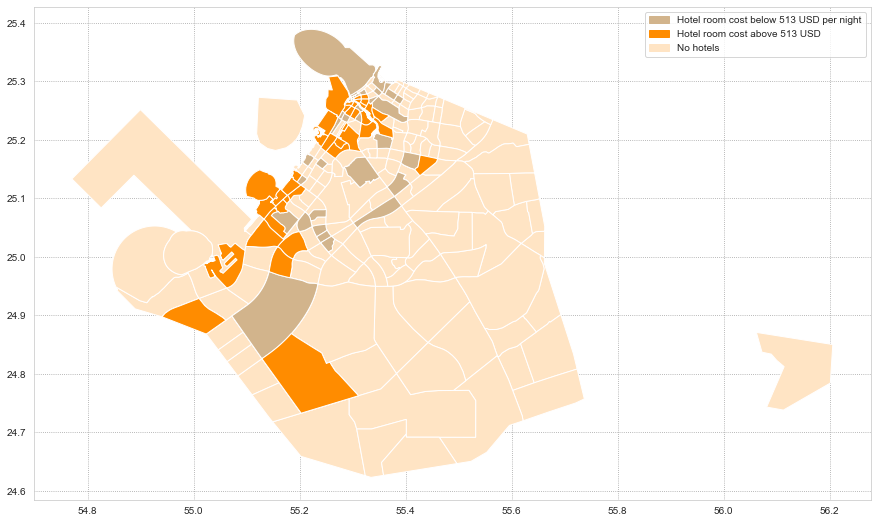

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
dubai_polygons.plot(ax=ax, cmap=dubaicolor)

cheapHotels.plot(ax=ax, cmap=cheapColor)
expensiveHotels.plot(ax=ax, cmap=expensiveColor)

cheapPatch = mpatches.Patch(color='tan', label='Hotel room cost below 513 USD per night')
expensivePatch = mpatches.Patch(color='darkorange', label='Hotel room cost above 513 USD')
noHotelPatch = mpatches.Patch(color='bisque', label='No hotels')

plt.legend(handles=[cheapPatch, expensivePatch, noHotelPatch])
plt.axis()

### **Section 5:** Point of interest proximity and concentration

In order to complement the core regression analysis of this workbook, which relies on determining the relationship between mall proxmity and hotel room rates in Dubai, externalities related to the concentrations of geospatial attributes are also considered.

Consequently, the distance from, and concentration of these geospatial externalities with repsect to the location of Dubai's hotels can be determined via the utilisation of a method that determines the point of interest count up until a certain radius around a hotel (determinePOICount) and the use of a method that can calculate the distance of an external feature from a hotel (CalculateDistance).

In [41]:
def determinePOICount(attribute, tag, threshold):
    counts = [];

    for i, row in dubai_hotels.iterrows():
        count = 0
        for j, location in attribute.iterrows():
            coords1 = (dubai_hotels.at[i, 'geometry'].y, dubai_hotels.at[i, 'geometry'].x)
            coords2 = (attribute.at[j, 'geometry'].y, attribute.at[j, 'geometry'].x)

            distance = geopy.distance.geodesic(coords1, coords2).m
            if(distance < threshold):
                count += 1

        counts.append(count)

    dubai_hotels[tag] = counts

In [42]:
def CalculateDistance(attribute, tag):
    distances = [];
    for i, row in dubai_hotels.iterrows():

        closest_distance= 1000000000000000

        for j, location in attribute.iterrows():
            coords1 = (dubai_hotels.at[i, 'geometry'].y, dubai_hotels.at[i, 'geometry'].x)
            coords2 = (attribute.at[j, 'geometry'].y, attribute.at[j, 'geometry'].x)
            distance = geopy.distance.geodesic(coords1, coords2).m    
            if(distance < closest_distance):
                closest_distance = distance
        distances.append(closest_distance)
    dubai_hotels[tag] = distances

The distance of each hotel from the three CBDs extracted earlier is calcualted and then appended to the 'dubal_hotels' dataframe.

In [43]:
CalculateDistance(cbd_centroids[cbd_centroids.index=='DIFC, Downtown and Business Bay'],'closest distance to CBD (DIFC, Downtown and Business Bay)')
CalculateDistance(cbd_centroids[cbd_centroids.index=='Media city, Internet city, and Knowledge park'],'closest distance to CBD (Media city, Internet city, and Knowledge park)')
CalculateDistance(cbd_centroids[cbd_centroids.index=='Deira and Bur Dubai'],'closest distance to CBD (Deira and Bur Dubai)')

Additionally, distances are also determined from each hotel to a specific large sized mall.

In [44]:
largeMalls = dubai_malls[dubai_malls['LargeMall'] == True]
print(largeMalls.columns)
largeMalls[['name', 'LargeMall', 'MediumMall', 'SmallMall']] # For condifdentiality the areas, and geometries of malls cannot be printed out here

Index(['name', 'geometry', 'area', 'LargeMall', 'MediumMall', 'SmallMall'], dtype='object')


,name,LargeMall,MediumMall,SmallMall
0,Deira City Centre,True,False,False
1,Dubai Mall,True,False,False
3,Dragon Mart,True,False,False
11,Ibn Battuta Mall,True,False,False
13,Mirdif City Center,True,False,False
19,Mall of the Emirates,True,False,False
40,Al Ghurair Center,True,False,False
49,Dragon Mart 2,True,False,False
50,Wafi Mall,True,False,False
81,The Outlet Village,True,False,False


In [45]:
for i, mall in largeMalls.iterrows():
    name = largeMalls.at[i, 'name']
    tag = 'closest distance to ' +  name
    subset  = largeMalls[largeMalls['name'] == name]
    CalculateDistance(subset, tag)

The distance a hotel is from it's closest medium and small sized mall is also determined.

In [46]:
MediumDistances = []
SmallDistances = []

mediumMall = False
smallMall = False

for i, row in dubai_hotels.iterrows():

    closest_large_mall_distance = 1000000000000000
    closest_medium_mall_distance = 1000000000000000
    closest_small_mall_distance = 1000000000000000

    for j, mall in dubai_malls.iterrows():
        coords1 = (dubai_hotels.at[i, 'geometry'].y, dubai_hotels.at[i, 'geometry'].x)
        coords2 = (dubai_malls.at[j, 'geometry'].y, dubai_malls.at[j, 'geometry'].x)
        distance = geopy.distance.geodesic(coords1, coords2).m    

        if(dubai_malls.at[j, 'MediumMall']):
            mediumMall = True

        else:
            smallMall = True

        if(mediumMall  & (distance < closest_medium_mall_distance)):
            closest_medium_mall_distance = distance

        if(smallMall  & (distance < closest_small_mall_distance)):
            closest_small_mall_distance = distance

        mediumMall = False
        smallMall = False

    MediumDistances.append(closest_medium_mall_distance)
    SmallDistances.append(closest_small_mall_distance)

dubai_hotels['closest medium mall distance'] = MediumDistances
dubai_hotels['closest small mall distance'] = SmallDistances

print(dubai_hotels.columns)

Index(['Hotel Name', 'Double High Rate', 'Rooms', 'geometry', 'Tract',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Media city, Internet city, and Knowledge park)',
       'closest distance to CBD (Deira and Bur Dubai)',
       'closest distance to Deira City Centre',
       'closest distance to Dubai Mall', 'closest distance to Dragon Mart',
       'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center',
       'closest distance to Mall of the Emirates',
       'closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village',
       'closest medium mall distance', 'closest small mall distance'],
      dtype='object')


Finally concentrations of transport links and traffic features within a 500 meter radius of each hotel in Dubai is determined.

This involves first specifying what these features are and then calculating distances for each hotel entry in the dataframe.

As can be observed below there are 6 categories of transport links and 17 categories of traffic features that are considered for this analysis.

In [47]:
dubai_transport_links = gpd.read_file('Data/Dubai Data/Transport/DubaiBusStops.shp')
dubai_transport_links = dubai_transport_links[['fclass', 'geometry']]
list(dubai_transport_links['fclass'].unique())


['bus_stop',
 'ferry_terminal',
 'railway_station',
 'taxi',
 'bus_station',
 'tram_stop']

In [48]:
dubai_bus_stop = dubai_transport_links[dubai_transport_links['fclass']=='bus_stop']
dubai_ferry_terminal = dubai_transport_links[dubai_transport_links['fclass']=='ferry_terminal']
dubai_railway_station = dubai_transport_links[dubai_transport_links['fclass']=='railway_station']
dubai_taxi = dubai_transport_links[dubai_transport_links['fclass']=='taxi']
dubai_bus_station = dubai_transport_links[dubai_transport_links['fclass']=='bus_station']
dubai_tram_stop = dubai_transport_links[dubai_transport_links['fclass']=='tram_stop']

In [49]:
dubai_traffic = gpd.read_file('Data/Dubai Data/Transport/DubaiTraffic.shp')
dubai_traffic = dubai_traffic[['fclass', 'geometry']]
list(dubai_traffic['fclass'].unique())

['traffic_signals',
 'motorway_junction',
 'crossing',
 'turning_circle',
 'mini_roundabout',
 'parking',
 'fuel',
 'marina',
 'parking_underground',
 'parking_multistorey',
 'stop',
 'slipway',
 'street_lamp',
 'speed_camera',
 'parking_bicycle',
 'lock_gate',
 'waterfall']

The following code determines the concentrations of transport links and traffic features within 500 meters of each hotel in Dubai.

In [50]:
determinePOICount(dubai_transport_links, 'Transport links within 500 meters', 500)

In [51]:
determinePOICount(dubai_traffic, 'Traffic features within 500 meters',500)

### **Section 6:** Regression

The final step of the analysis presented in this workbook involves determining the dependent and independent variables that will be utilised in the regression analysis a process that will involve the consideration of Variance Inflation Factors and the nature of the distribution of each independent variable, in order to determine the exsitance or lack thereof a linear relationship.

If a Variance Inflation Factor score is determined to be excessive a variable is removed, likewise the existance of a non-normal frequency distribution will involve the utilisation of a log transformation for an independent variable.

First the columns that exist within the dataframe that is created above can be highlighted as follows.

In [52]:
dubai_hotels.reset_index(inplace=True)
dubai_hotels.columns

Index(['index', 'Hotel Name', 'Double High Rate', 'Rooms', 'geometry', 'Tract',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Media city, Internet city, and Knowledge park)',
       'closest distance to CBD (Deira and Bur Dubai)',
       'closest distance to Deira City Centre',
       'closest distance to Dubai Mall', 'closest distance to Dragon Mart',
       'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center',
       'closest distance to Mall of the Emirates',
       'closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village',
       'closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters',
       'Traffic features within 500 meters'],
      dtype='object')

Redundant and unnecssary columns can then be dropped.

In [53]:
dubai_hotels.drop('index', axis=1, inplace=True)
dubai_hotels.drop('Tract', axis=1, inplace=True)

Following this, dependent and independent variables can be extracted.

In [54]:
dependent_variable = dubai_hotels['Double High Rate'];

In [55]:
indpendent_variables = dubai_hotels.drop('Double High Rate', axis=1)
indpendent_variables.drop('Hotel Name', axis=1, inplace=True)
indpendent_variables.drop('geometry', axis=1, inplace=True)

A logarithmic version of each independent variable is added to the 'dubai_hotels' dataframe below.

In [56]:
for tag in indpendent_variables.columns:
    variable = dubai_hotels[tag]
    log_variable = np.log(variable)
    newName = 'log '+ tag
    dubai_hotels[newName] = log_variable    
print(dubai_hotels.columns)


Index(['Hotel Name', 'Double High Rate', 'Rooms', 'geometry',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Media city, Internet city, and Knowledge park)',
       'closest distance to CBD (Deira and Bur Dubai)',
       'closest distance to Deira City Centre',
       'closest distance to Dubai Mall', 'closest distance to Dragon Mart',
       'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center',
       'closest distance to Mall of the Emirates',
       'closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village',
       'closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters',
       'Traffic features within 500 meters', 'log Rooms',
       'log closest distance to CBD (DIFC, Downtown and Business Bay)',
       'log closest distance to CBD (Media 

c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


A visual representation of the frequency distribution of values for each variable is highlighted below using the generate graph function.

In [57]:
def generateGraph(variable, variable_tag, counts):
    try:
        ax = plt.gca()
        ax.hist(variable)
        ax.set_xlabel(variable_tag)
        ax.set_ylabel('Count')
        ax.set_title(variable_tag+" vs "+ 'Count')

        plt.show()
    except:
        print('Error')

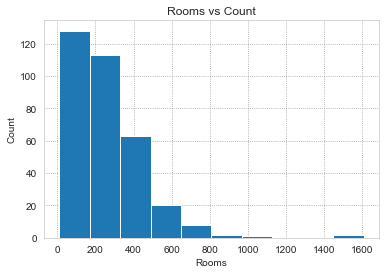

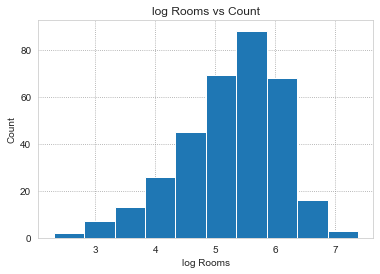

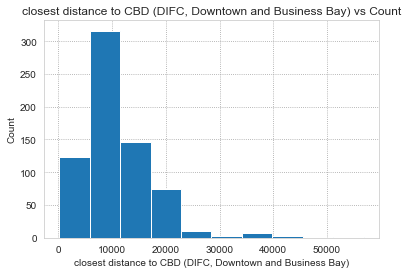

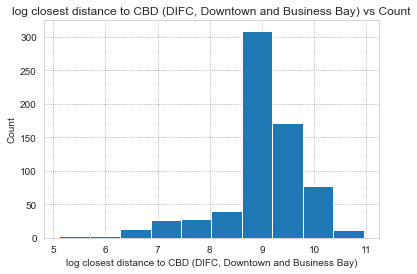

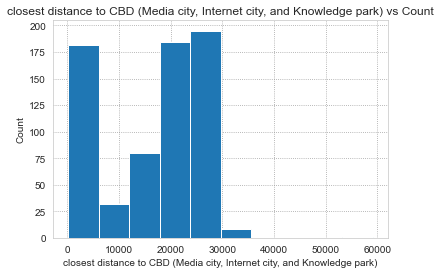

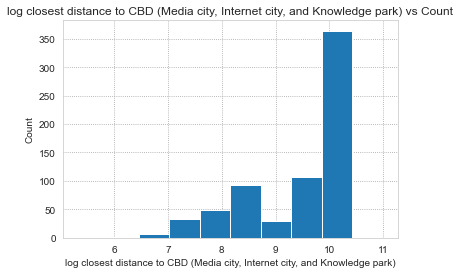

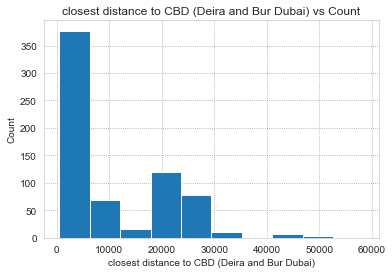

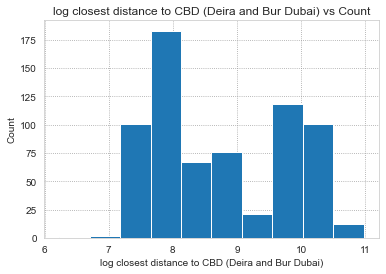

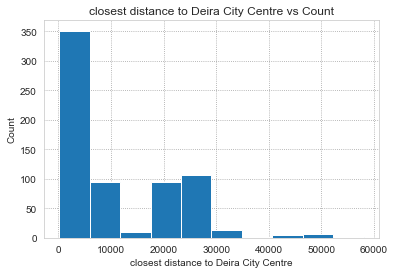

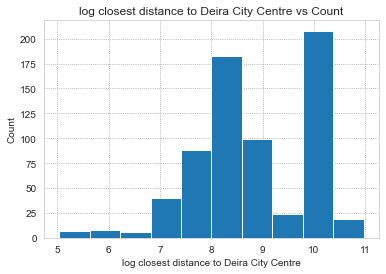

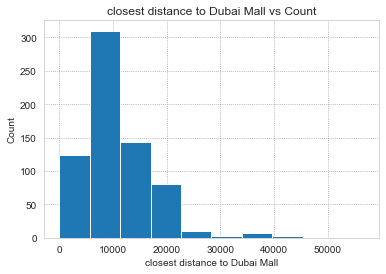

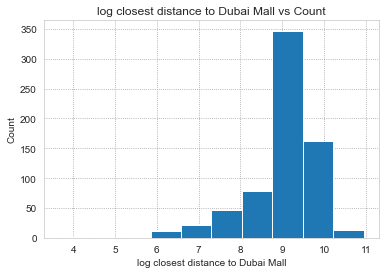

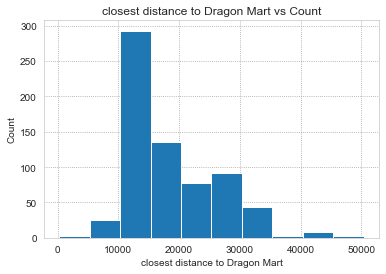

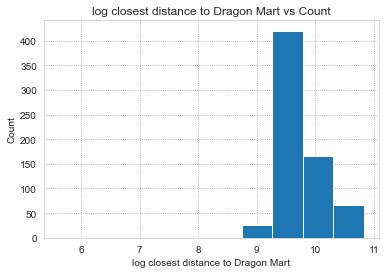

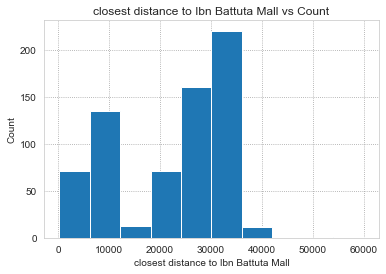

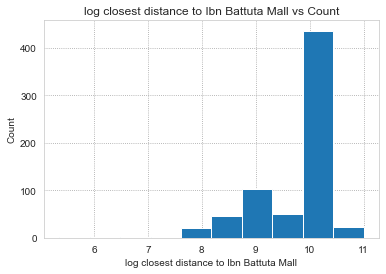

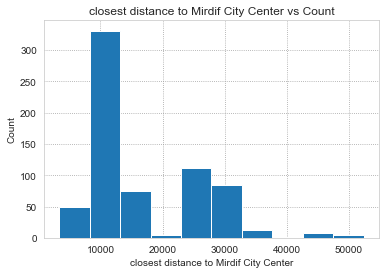

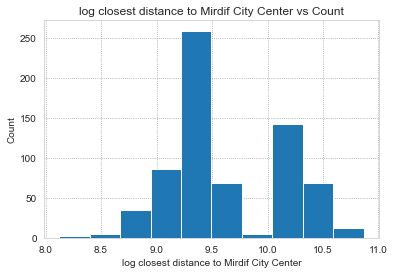

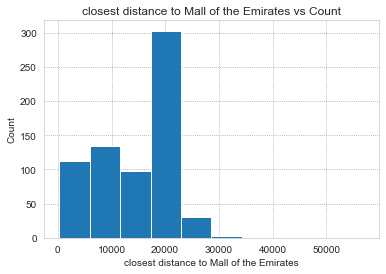

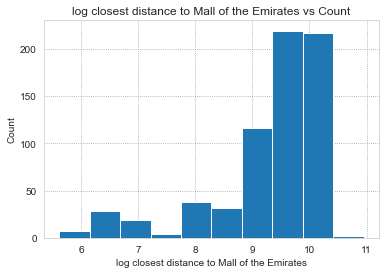

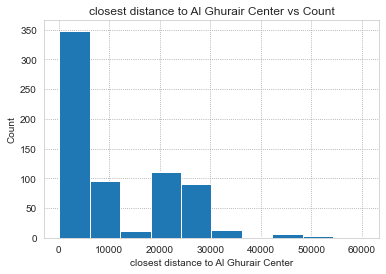

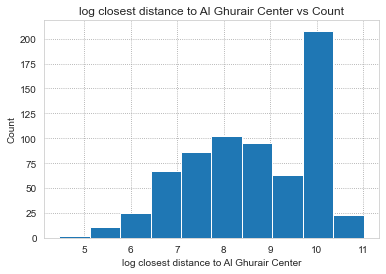

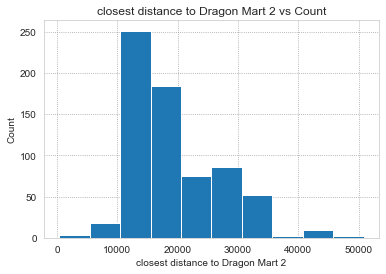

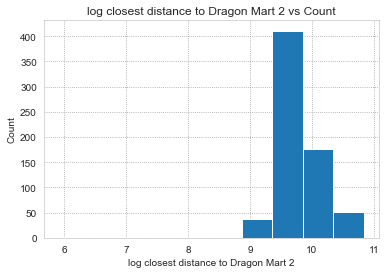

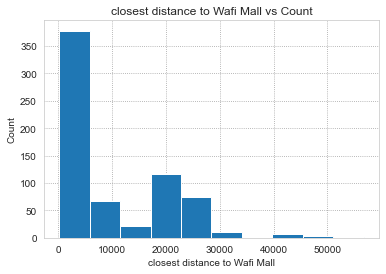

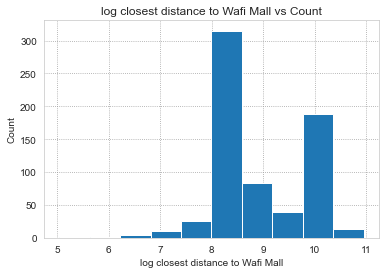

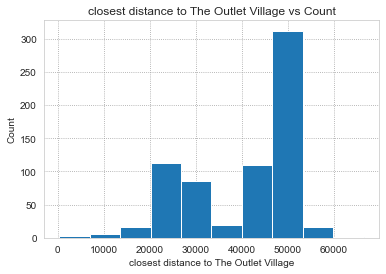

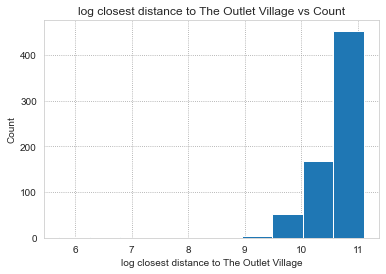

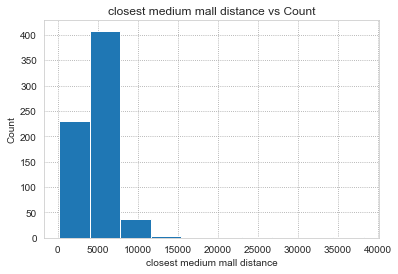

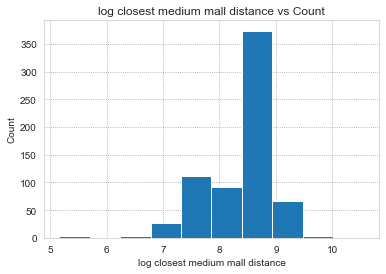

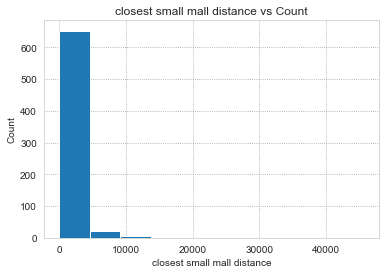

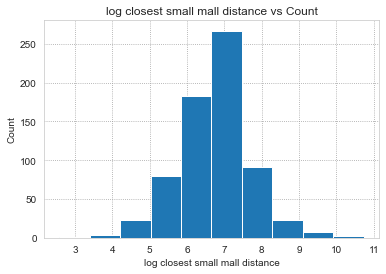

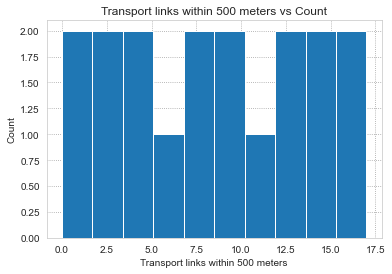

Error


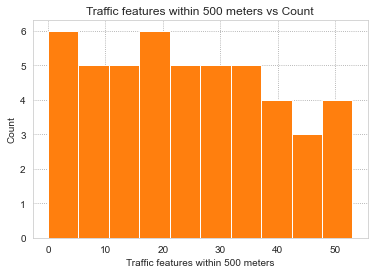

Error


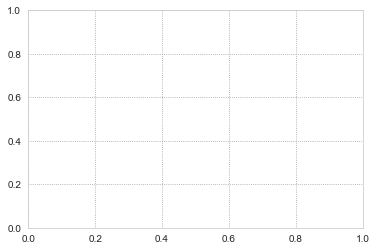

In [58]:
for tag in indpendent_variables.columns:
    if(tag!='index'):
        variable = dubai_hotels[tag]
        value_by_count = variable.value_counts().to_dict()
        generateGraph(list(value_by_count.keys()), tag, list(value_by_count.values()))

        log_tag = 'log '+ tag
        log_variable = dubai_hotels[log_tag]
        value_by_count = log_variable.value_counts().to_dict()
        generateGraph(list(value_by_count.keys()), log_tag, list(value_by_count.values()))

As can be observed only certain variables require a log-transformation in order to be normally distributed, columns for log-transformed variables that are not in requirement of such a transformation can be dropped from the dataframe prior to further regression analysis.

In [59]:
list(dubai_hotels.columns)

['Hotel Name',
 'Double High Rate',
 'Rooms',
 'geometry',
 'closest distance to CBD (DIFC, Downtown and Business Bay)',
 'closest distance to CBD (Media city, Internet city, and Knowledge park)',
 'closest distance to CBD (Deira and Bur Dubai)',
 'closest distance to Deira City Centre',
 'closest distance to Dubai Mall',
 'closest distance to Dragon Mart',
 'closest distance to Ibn Battuta Mall',
 'closest distance to Mirdif City Center',
 'closest distance to Mall of the Emirates',
 'closest distance to Al Ghurair Center',
 'closest distance to Dragon Mart 2',
 'closest distance to Wafi Mall',
 'closest distance to The Outlet Village',
 'closest medium mall distance',
 'closest small mall distance',
 'Transport links within 500 meters',
 'Traffic features within 500 meters',
 'log Rooms',
 'log closest distance to CBD (DIFC, Downtown and Business Bay)',
 'log closest distance to CBD (Media city, Internet city, and Knowledge park)',
 'log closest distance to CBD (Deira and Bur Dubai)'

Only the following independent variables need be considered.

In [60]:
final_independent_variables = dubai_hotels[[
 'log Rooms',
 'closest distance to CBD (DIFC, Downtown and Business Bay)',
 'closest distance to CBD (Media city, Internet city, and Knowledge park)',
 'closest distance to CBD (Deira and Bur Dubai)',
 'closest distance to Deira City Centre',
 'closest distance to Dubai Mall',
 'closest distance to Dragon Mart',
 'closest distance to Ibn Battuta Mall',
 'closest distance to Mirdif City Center',
 'closest distance to Mall of the Emirates',
 'closest distance to Al Ghurair Center',
 'closest distance to Dragon Mart 2',
 'closest distance to Wafi Mall',
 'closest distance to The Outlet Village',
 'closest medium mall distance',
 'log closest small mall distance',
 'Transport links within 500 meters',
 'Traffic features within 500 meters']]

Columns can now be iteratively dropped based on their Variance Inflation Factor scores in order to prevent further regression analysis from being affected by multicolliearity.

The following function is from Quantitative Methods tutorial 4 (CASA0007) 
It calculates the VIF score of each independent variable and returns a dataframe containing independent variables that have a VIF score that is below 10

Source: https://moodle.ucl.ac.uk/pluginfile.php/3532739/mod_resource/content/6/Practical_advanced_regression_UPDATED.ipynb

In [61]:
def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF.
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
                            for i in range(df_with_const.shape[1])],
                           name="VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed.
        # This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

The utilisation of the above function removes the following variables from subsequent consideration in regression analysis.

In [62]:
final_independent_variables_vif = drop_column_using_vif_(final_independent_variables)
print(final_independent_variables_vif.columns)

Dropping: closest distance to Dragon Mart
Dropping: closest distance to Dubai Mall
Dropping: closest distance to CBD (Deira and Bur Dubai)
Dropping: closest distance to Deira City Centre
Dropping: closest distance to Mirdif City Center
Dropping: closest distance to Wafi Mall
Dropping: closest distance to CBD (Media city, Internet city, and Knowledge park)
Dropping: closest distance to The Outlet Village
Dropping: closest distance to Ibn Battuta Mall
Dropping: closest distance to Al Ghurair Center
Index(['log Rooms',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to Mall of the Emirates',
       'closest distance to Dragon Mart 2', 'closest medium mall distance',
       'log closest small mall distance', 'Transport links within 500 meters',
       'Traffic features within 500 meters'],
      dtype='object')


Finally, ordinary least squares linear regression is performed.

In [63]:
# Performing regression and extracting summary
stats = sm.OLS(endog=dependent_variable, exog=final_independent_variables_vif).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       Double High Rate   R-squared (uncentered):                   0.427
Model:                            OLS   Adj. R-squared (uncentered):              0.420
Method:                 Least Squares   F-statistic:                              62.95
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                    9.65e-77
Time:                        10:06:24   Log-Likelihood:                         -4666.1
No. Observations:                 684   AIC:                                      9348.
Df Residuals:                     676   BIC:                                      9384.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
log Rooms                                                    68.0257     10.103      6.733      0.000      48.189      87.862
closest distance to CBD (DIFC, Downtown and Business Bay)    -0.0081      0.003     -3.012      0.003      -0.013      -0.003
closest distance to Mall of the Emirates                     -0.0024      0.002     -1.316      0.189      -0.006       0.001
closest distance to Dragon Mart 2                             0.0061      0.003      2.283      0.023       0.001       0.011
closest medium mall distance                                  0.0110      0.004      2.485      0.013       0.002       0.020
log closest small mall distance                             -26.1254      8.235     -3.172      0.002     -42.295      -9.956
Transport links within 500 meters                            -9.2265      2.706     -3.410      0.001     -14.539      -3.914
Traffic features within 500 meters                           -2.0809      0.815     -2.553      0.011      -3.681      -0.480
==============================================================================
Omnibus:                      317.310   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1510.069
Skew:                           2.124   Prob(JB):                         0.00
Kurtosis:                       8.911   Cond. No.                     3.83e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""